In [2]:
# default_exp raster_process

In [3]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler
! [ -e /content ] && pip install -Uqq git+https://github.com/butchland/nbdev.git@add-black-format
# downgrade tornado if in colab
! [ -e /content ] && pip install -Uqq tornado==5.1.0

In [4]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Raster Processing

> Utilities for processing raster data

In [53]:
# hide
from pathlib import Path, PosixPath

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from rasterio.plot import show
from geowrangler import grids

In [54]:
from pathlib import PosixPath
from typing import Union

# hide
# export
import rasterio as rio
import rasterio.mask
from rasterio.io import DatasetReader
from shapely.geometry import Polygon

In [10]:
# export


def query_window_by_polygon(
    input_raster: Union[str, DatasetReader, PosixPath],
    output_path: str,
    geometry: Polygon,
    mask=False,
) -> None:
    """Query a cloud-optimized geotiff based on polygon and save to disk
    Returns a subset of a rasterio dataset based on a window
    defined by (left,right,bottom,top) coordinates. This function
    assumes that the CRS of the bounds is based on the input dataset

    Args:
        input_raster (str, DatasetReader, PosixPath): Input rasterio dataset, which can be specified
            by a local filename or an open rasterio dataset
        output_path (str): Path to save output file
        geometry (polygon): polygon to crop
    Returns:
        None

    Cloud optimized geotiffs are also supported, which allows you
    to query a geotiff hosted in an HTTP server.

    """

    # If input_raster is specified as PosixPath, convert to string explicitly
    if isinstance(input_raster, PosixPath):
        input_raster = str(input_raster)

    # # Open new dataset if input is a path to a file
    # if isinstance(input_raster,str):
    #     input_dset = rio.open(input_raster)
    # else:
    #     input_dset = input_raster

    # get the window_bounds for the geometry
    window_bounds = geometry.bounds

    # Check that window_bounds has the correct number of elements
    assert (
        len(window_bounds) == 4
    ), "window_bounds must have exactly four items (left,bottom,right,top)"

    # Unroll window_bounds
    left, bottom, right, top = window_bounds

    with rio.open(input_raster) as input_dst:

        # Get profile of input_dset
        input_profile = input_dst.profile

        # Specify window and query subset
        window = rio.windows.from_bounds(left, bottom, right, top, input_dst.transform)
        subset = input_dst.read(window=window)

        # Get the shape of the output subset
        number_of_bands, height, width = subset.shape

        # Get the transformation of the subset based on the window
        win_transform = input_dst.window_transform(window)

        # Update metadata for output
        output_profile = input_profile.copy()
        update_params = {
            "count": number_of_bands,
            "height": height,
            "width": width,
            "transform": win_transform,
        }
        output_profile.update(update_params)

        # Write image to output_file
        with rio.open(output_path, "w", **output_profile) as output_dst:
            output_dst.write(subset)
            output_dst.colorinterp = input_dst.colorinterp

    if mask:
        with rio.open(output_path) as dst:
            masked_image, masked_transform = rio.mask.mask(dst, [geometry], crop=True)
        with rio.open(output_path, "w", **output_profile) as output_dst:
            update_params = {
                "height": masked_image.shape[1],
                "width": masked_image.shape[2],
                "transform": masked_transform,
            }
            output_profile.update(update_params)
            output_dst.write(masked_image)

    return

In [79]:
# export


def query_window_by_gdf(
    input_raster: Union[str, DatasetReader, PosixPath],
    output_folder: str,
    gdf,
    name_col=None,
    mask=False,
) -> None:
    """Query a subset of a geotiff based on a window and save to disk
    Returns a subset of a rasterio dataset based on a window
    defined by (left,right,bottom,top) coordinates. This function
    assumes that the CRS of the bounds is based on the input dataset

    Cloud optimized geotiffs are also supported, which allows you
    to query a geotiff hosted in an HTTP server.

    Args:
        input_raster (str, DatasetReader, PosixPath): Input rasterio dataset, which can be specified
            by a local filename or an open rasterio dataset
        output_folder (str): Path to save output file
        gdf,
        name_col (str): column name to base output filepath on. If none, outputs will be named sequentially
            as `output_0.tif`
    Returns:
        None
    """

    gdf = gdf.copy()

    # Check CRS match
    with rio.open(input_raster) as dst:
        assert dst.meta["crs"] == gdf.crs, "input_raster and gdf CRS must match!"

    if name_col is None:
        name_col = "name"
        gdf[name_col] = "output_" + gdf.reset_index().index.astype(str) + ".tif"
    else:
        gdf[name_col] = gdf[name_col] + ".tif"

    for i, row in gdf.iterrows():
        polygon = row.geometry
        output_name = row[name_col]
        output_path = output_folder / output_name
        print(output_path)
        query_window_by_polygon(input_raster, output_path, polygon, mask)

## Download raster

In [12]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/phl_ppp_2020_constrained.tif ] && curl -s -o ../data/phl_ppp_2020_constrained.tif https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/phl_ppp_2020_constrained.tif

In [13]:
input_image = "../data/phl_ppp_2020_constrained.tif"

In [14]:
raster = rio.open(input_image)
raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 11613,
 'height': 19781,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008333333299750276, 0.0, 116.927916214,
        0.0, -0.0008333333300136493, 21.070416784)}

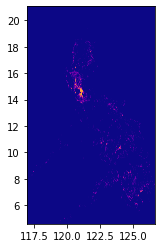

<AxesSubplot:>

In [15]:
show(raster.read(1), cmap="plasma", transform=raster.transform)

## Define bounding box

In [16]:
bbox = (120.888062, 14.394778, 121.199112, 14.705822)

In [17]:
# hide
def make_circle_geometry(lat, lon, buffer, crs="epsg:4326"):
    df = pd.DataFrame({"lat": [lat], "lon": [lon]})
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=crs)
    gdf["geometry"] = gdf["geometry"].buffer(buffer)
    return gdf

In [18]:
# hide
circle_gdf = make_circle_geometry(14.599512, 120.984222, 1)

/tmp/ipykernel_369/1262692130.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer)


In [19]:
circle_gdf

,lat,lon,geometry
0,14.599512,120.984222,"POLYGON ((121.98422 14.59951, 121.97941 14.501..."


In [20]:
print(circle_gdf.crs)

epsg:4326


<AxesSubplot:>

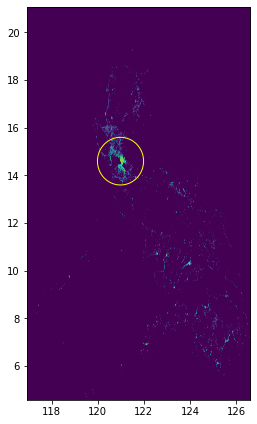

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 8))
show(raster.read(1), cmap="viridis", ax=ax, transform=raster.transform)
circle_gdf.plot(ax=ax, facecolor="none", edgecolor="yellow")

ax

## Crop a raster without masking

In [24]:
output_folder = Path("../data")

In [27]:
query_window_by_gdf(input_image, output_folder, circle_gdf, mask=False)

../data/output_0.tif


[[-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 ...
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]]


<AxesSubplot:>

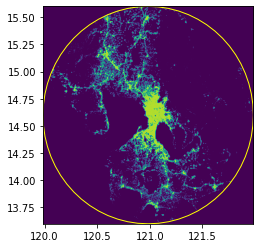

In [28]:
with rio.open(output_folder / "output_0.tif") as dst:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    show(dst.read(1), cmap="viridis", ax=ax, transform=dst.transform)
    circle_gdf.plot(facecolor="none", edgecolor="yellow", ax=ax)
    print(dst.read(1))
ax

## Crop a raster with masking

## Crop on multiple geometries at once

In [ ]:
# hide
def make_circle_geometry(lat, lon, buffer, crs="epsg:4326"):
    df = pd.DataFrame({"lat": [lat], "lon": [lon]})
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=crs)
    gdf["geometry"] = gdf["geometry"].buffer(buffer)
    return gdf

In [55]:
grid_generator = grids.SquareGridGenerator(100_000)

In [72]:
grid_gdf = grid_generator.generate_grid(circle_gdf)
grid_gdf["name"] = (
    "gridxy-" + grid_gdf["x"].astype(str) + "-" + grid_gdf["y"].astype(str)
)

In [73]:
grid_gdf

,x,y,geometry,name
0,0,0,"POLYGON ((119.98422 13.59951, 120.88254 13.599...",gridxy-0-0
1,0,1,"POLYGON ((119.98422 14.47100, 120.88254 14.471...",gridxy-0-1
2,0,2,"POLYGON ((119.98422 15.33908, 120.88254 15.339...",gridxy-0-2
3,1,0,"POLYGON ((120.88254 13.59951, 121.78085 13.599...",gridxy-1-0
4,1,1,"POLYGON ((120.88254 14.47100, 121.78085 14.471...",gridxy-1-1
5,1,2,"POLYGON ((120.88254 15.33908, 121.78085 15.339...",gridxy-1-2
6,2,0,"POLYGON ((121.78085 13.59951, 122.67917 13.599...",gridxy-2-0
7,2,1,"POLYGON ((121.78085 14.47100, 122.67917 14.471...",gridxy-2-1


<AxesSubplot:>

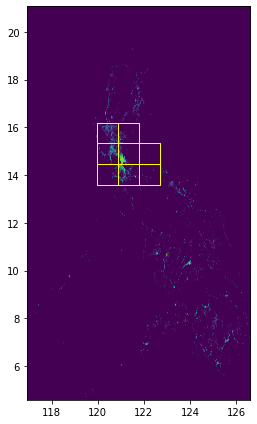

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(4, 8))
show(raster.read(1), cmap="viridis", ax=ax, transform=raster.transform)
grid_gdf.plot(ax=ax, facecolor="none", edgecolor="yellow")

ax

In [80]:
query_window_by_gdf(input_image, output_folder, grid_gdf, name_col="name", mask=False)

../data/gridxy-0-0.tif
../data/gridxy-0-1.tif
../data/gridxy-0-2.tif
../data/gridxy-1-0.tif
../data/gridxy-1-1.tif
../data/gridxy-1-2.tif
../data/gridxy-2-0.tif
../data/gridxy-2-1.tif


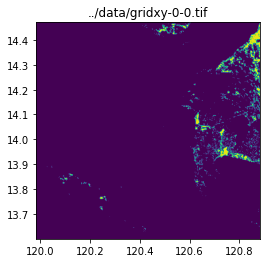

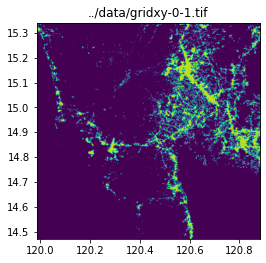

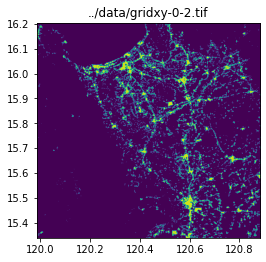

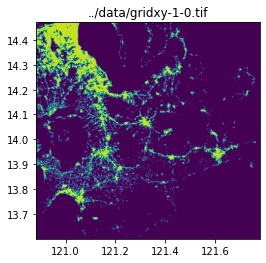

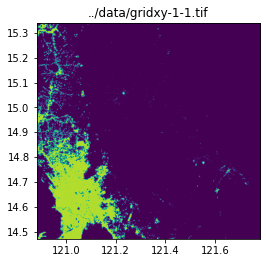

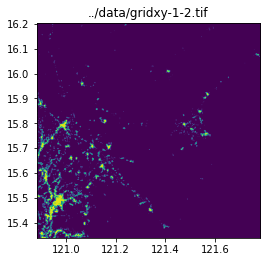

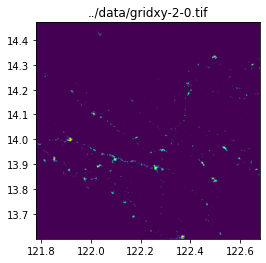

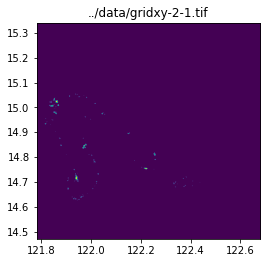

In [87]:
for name in grid_gdf["name"]:
    image_path = output_folder / (name + ".tif")
    with rio.open(image_path) as dst:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.set_title(image_path)
        show(dst.read(1), cmap="viridis", ax=ax, transform=dst.transform)

## Crop on cloud optimized geotiff